Exploring the data

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import sys
import importlib
import functions.functions as aux_fun
importlib.reload(aux_fun)
from datetime import datetime as dti

pd.options.mode.chained_assignment = None 

Reading data

In [2]:
# Read data

# Portifolio and profile datasets
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)

# User and offer data, already treated in Data Preparation 
user_offer_df = pd.read_csv('user_offer.csv').astype({'offer_id_rec':np.int8})

# Reading the hexideciamal to int dictonaries
map_portifolio = json.load(open('mapper_id/portifolio_ids.json'))
map_profile = json.load(open('mapper_id/profile_ids.json'))

Quick look at the data

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
user_offer_df.head()

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3
1,3,1.0,1.0,37.67,1.0,1.0,5.0,3
2,0,1.0,1.0,48.28,1.0,1.0,10.0,3
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3
4,4,1.0,0.0,1.09,1.0,NaN,0.0,4


#### Data preparation for analysis

##### 1. Profile

Preparing the profile and portifolio datasets to analysis.  

It is necessary create a column for interger ids

In [6]:
# Profile
profile['user_id'] = profile.id.map(map_profile)

For the profile dataset, there are some users with a fixed age of 118.   
Observing the other data, it is noted that users who are not registrant such information such as genre, age and income.The only information it appears is when the user became a member.

In [7]:
# For profile, calculate the 

profile.loc[pd.isna(profile.gender)].head()

,gender,age,id,became_member_on,income,user_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,6
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,7


In [8]:
profile.loc[pd.isna(profile.gender)].shape[0] / profile.shape[0]

0.12794117647058822

12% of total users has no data for gender, age and income

To create one more feature for users, the time they are member, in relation to the latest user, since the date of collecting the data is not known.  

It is worth mentioning that even for users without information, this data is present at the dataset

In [9]:
# Convert to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
# Get the newest user in data
most_recent_mem_data = profile['became_member_on'].max()
# Creating a extra column to put number of days compared with newest
profile['rela_member_days'] = (most_recent_mem_data - profile['became_member_on']).dt.days

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_days
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,376
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,443
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,4,356


For gender data, the voids are replaced by not informed.  
For application in models, this category could be treated separately later

In [10]:
# Replace NaN gender with NI (not informed)
profile['gender'] = profile['gender'].fillna('NI')

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_days
0,NI,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,376
2,NI,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,443
4,NI,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,4,356


For income, all the users are part of the group that did not also inform the age and gender.  

For this case, the distribution of income to check if the average may be a good choice 

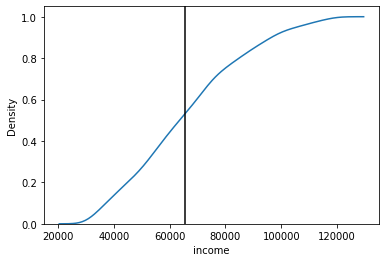

Mean income: 65404.9915682968
Median income: 64000.0


In [11]:
# Distribuition of income
sns.kdeplot(data=profile, x='income', cumulative=True)
plt.axvline(x=profile["income"].mean(), color='black')
plt.show()

print(f'Mean income: {profile["income"].mean()}')
print(f'Median income: {profile["income"].median()}')

65 thousand is the average and 64 thousand the median, which shows that 50% of the values are close to that value.  
Thus, assigning the median to the missing values will not change the distributions significantly.

In [12]:
# Fill na with mean

profile['income'] = profile['income'].fillna(profile.income.median())

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_days
0,NI,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,376
2,NI,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,443
4,NI,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,356


Por último, o valor de 118 no campo de idade pode atrapalhar nas análise. Assim, para esses valores, também se usará a mediana das idades como substituto.

In [13]:
# Fill 118 values with meadian, without this extreme value
profile.loc[profile.age == 118, 'age'] = profile.loc[profile.age != 118, 'age'].median()

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_days
0,NI,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,529
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,376
2,NI,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,14
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,443
4,NI,55.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,356


##### 2. Portifolio

First, create the integer id column for portifolio

In [14]:
# Portifolio
portfolio['offer_id'] = portfolio.id.map(map_portifolio)

portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4


##### 3. Merging datasets

Merging the user offer dataset with profile and portifolio dataset  

The extra information will be used to exploring the data.

In [15]:
# Just interesting columns from profile and portifolio
# Profile
profile2 = profile[['user_id', 'gender', 'age', 'income', 'rela_member_days']]

# Portifolio
portfolio2 = portfolio[['offer_id', 'reward', 'difficulty', 'offer_type']]
portfolio2.columns = ['offer_id', 'offer_reward', 'offer_difficulty', 'offer_type']

# Merging with user_offer_id

user_offer_df2 =  user_offer_df.merge(portfolio2, left_on='offer_id_rec', right_on='offer_id')
user_offer_df2 = user_offer_df2.merge(profile2, on='user_id')

user_offer_df2.head() 



,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_days
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,informational,F,75.0,100000.0,443
1,3,1.0,1.0,37.67,1.0,1.0,5.0,3,3,5,5,bogo,F,75.0,100000.0,443
2,0,1.0,1.0,48.28,1.0,1.0,10.0,3,0,10,10,bogo,F,75.0,100000.0,443
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,bogo,F,75.0,100000.0,443
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,informational,NI,55.0,64000.0,356


Informações contínuas, como renda e idade podem ser melhor analisadas a partir do seu agrupamento.  
O melhor agrupamento para uma única variável é nos quartis, separando os dados em 4 partes iguais.

In [68]:
user_offer_df2['age_quartile'] = pd.qcut(user_offer_df2['age'], q=4)
user_offer_df2['income_quartile'] = pd.qcut(user_offer_df2['income'], q=4)

user_offer_df2.head()

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,user_id,offer_id,offer_reward,offer_difficulty,offer_type,gender,age,income,rela_member_days,age_quartile,income_quartile
0,7,1.0,0.0,49.39,1.0,NaN,0.0,3,7,0,0,informational,F,75.0,100000.0,443,"(65.0, 101.0]","(76000.0, 120000.0]"
1,3,1.0,1.0,37.67,1.0,1.0,5.0,3,3,5,5,bogo,F,75.0,100000.0,443,"(65.0, 101.0]","(76000.0, 120000.0]"
2,0,1.0,1.0,48.28,1.0,1.0,10.0,3,0,10,10,bogo,F,75.0,100000.0,443,"(65.0, 101.0]","(76000.0, 120000.0]"
3,8,1.0,1.0,0.00,1.0,0.0,5.0,3,8,5,5,bogo,F,75.0,100000.0,443,"(65.0, 101.0]","(76000.0, 120000.0]"
4,7,0.0,0.0,0.00,NaN,NaN,0.0,4,7,0,0,informational,NI,55.0,64000.0,356,"(45.0, 55.0]","(51000.0, 64000.0]"


#### Exploring the data

Questions  

1. Number of distributed offers
2. Number of type of offers distributed
3. Age of age, income, home and sex time
4. Fee transactions influenced by the offer by the same fields

##### 1. Quantity of offers sent

Number of offers sent by type

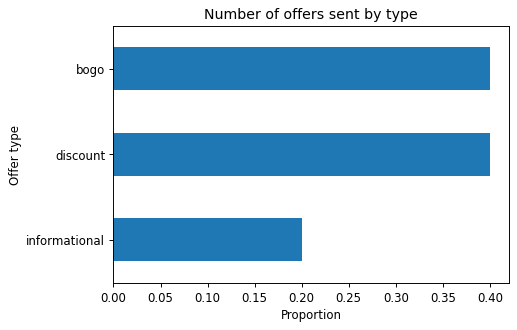

informational    0.200345
discount         0.400010
bogo             0.399645
Name: offer_type, dtype: float64

In [96]:
import functions.functions as aux_fun
importlib.reload(aux_fun)

aux_fun.plot_by_category_count(df=user_offer_df2,
    col_category='offer_type',
    title='Number of offers sent by type',
    x_label='Proportion',
    y_label='Offer type',
    return_table=True
)

Data are generated by simulation, it is noted that the proportion of the types of offers sent is distributed by 40% for bogo type, 40% for discount and 20% for informational.  

For the same reason, the same must be seen in the distribution by offer id

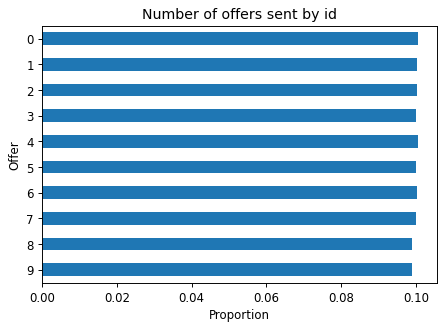

9    0.099072
8    0.098945
7    0.100086
6    0.100181
5    0.100086
4    0.100671
3    0.099895
2    0.100260
1    0.100165
0    0.100640
Name: offer_id_rec, dtype: float64

In [97]:
# plot_df = user_offer_df2['offer_id_rec'].value_counts().\
#     sort_index(ascending=False) / user_offer_df2.shape[0]

# plt.figure(dpi=85)
# plot_df.plot.barh()
# plt.title('Number of offers sent by id')
# plt.xlabel('Proportion')
# plt.ylabel('Offer ID')
# plt.show()

aux_fun.plot_by_category_count(df=user_offer_df2,
    col_category='offer_id_rec',
    title='Number of offers sent by id',
    x_label='Proportion',
    y_label='Offer',
    return_table=True
)

Exact, the data were generated with the same porportion for all offer ids present in portifolio

For profile data, it is noteworthy that only 6 users have not received any offer.

In [18]:
np.setdiff1d(profile2['user_id'], user_offer_df2['user_id'])

array([  872,  5425,  5639,  6789, 14763, 15391], dtype=int64)

Because of this, the distribution of offer data are very close to the distribution of profile data

For income data, separates the continuous value into quartiles to check distribuition of offers

TODO CONTINUAR DAQUI

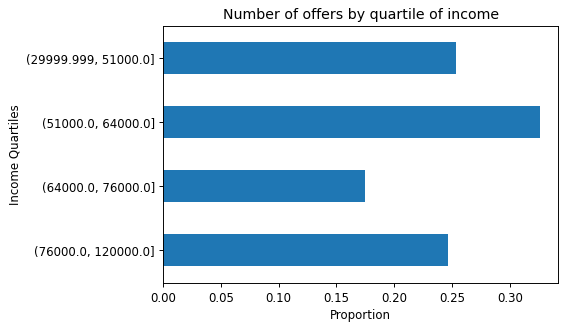

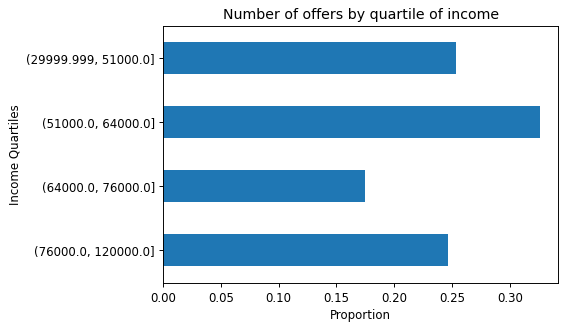

(76000.0, 120000.0]     0.246635
(64000.0, 76000.0]      0.174611
(51000.0, 64000.0]      0.325690
(29999.999, 51000.0]    0.253064
Name: income_quartile, dtype: float64

In [98]:
plot_df = pd.qcut(user_offer_df2['income'], q=4).value_counts(). \
    sort_index(ascending=False) / user_offer_df2.shape[0]

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('Number of offers by quartile of income')
plt.xlabel('Proportion')
plt.ylabel('Income Quartiles')
plt.show()

aux_fun.plot_by_category_count(df=user_offer_df2,
    col_category='income_quartile',
    title='Number of offers by quartile of income',
    x_label='Proportion',
    y_label='Income Quartiles',
    return_table=True
)

For income, more offers were sent to quartile where there are more people.The income group that least received offers was the third.

For gender

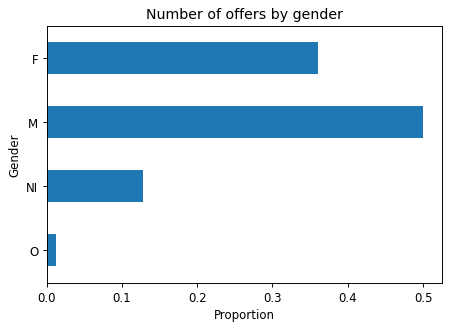

In [20]:
plot_df = user_offer_df2['gender'].value_counts().\
    sort_index(ascending=False) / user_offer_df2.shape[0]

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('Number of offers by gender')
plt.xlabel('Proportion')
plt.ylabel('Gender')
plt.show()

More offers were sent to male, putting with the distribution of this category on the profile base

##### 2. Visualization of offers

The first step for an offer to have effect on the user is to view it.  

Visualizations by Type of Offer

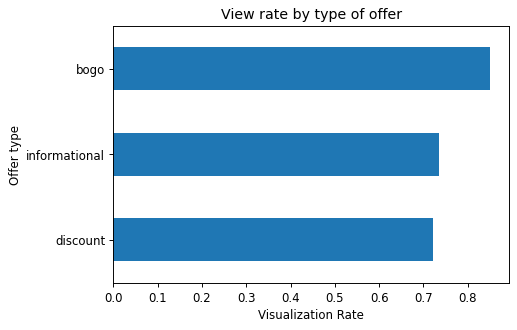

offer_type
discount         0.721446
informational    0.735831
bogo             0.850412
Name: viewed_rate, dtype: float64

In [21]:
plot_df = user_offer_df2.groupby('offer_type')['viewed_rate'].mean().\
    sort_values(ascending=True)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer type')
plt.show()

plot_df

What looks like is that buy-one get one offers has a slightly larger viewing fee compared to the other two.

Fact that proportions are not really so far from one another
However, it is possible to test whether these proportions are statistically different with a test of proprotions between independent samples (and considering that they are normal).

In [22]:
# Proportion test between two samples
# The test is one-tailed greater than

list_set = [['bogo', 'informational'], ['bogo', 'discount'], ['informational', 'discount']]

for set_ in list_set:
    aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='offer_type', 
        cat1=set_[0], cat2=set_[1], metric='viewed_rate')

p-value of 0.0. With confidence value of 0.05, bogo and informational distributions are different
p-value of 0.0. With confidence value of 0.05, bogo and discount distributions are different
p-value of 0.002. With confidence value of 0.05, informational and discount distributions are different


Then, statistically, despite close proportions between infromational and discount, the three types of offers have different viewing proportions

Visualizations by offer id

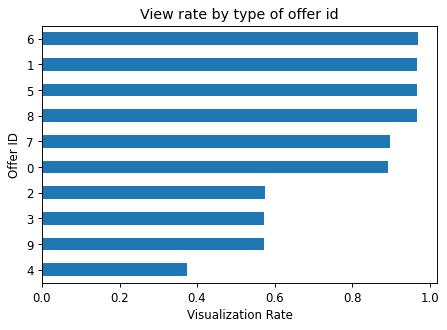

offer_id_rec
4    0.374862
9    0.572091
3    0.572448
2    0.574159
0    0.893312
7    0.897785
8    0.967670
5    0.967880
1    0.968696
6    0.971230
Name: viewed_rate, dtype: float64

In [23]:
plot_df = user_offer_df2.groupby('offer_id_rec')['viewed_rate'].mean().\
    sort_values(ascending=True)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer id')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer ID')
plt.show()

plot_df

Six offers has visualization fee greater than 80%.Three have a rate greater than 50%.One, the offer with ID 4 has a low view rate.  

Looking at portifolio dataset

In [24]:
portfolio[['offer_id', 'channels']]

,offer_id,channels
0,0,"[email, mobile, social]"
1,1,"[web, email, mobile, social]"
2,2,"[web, email, mobile]"
3,3,"[web, email, mobile]"
4,4,"[web, email]"
5,5,"[web, email, mobile, social]"
6,6,"[web, email, mobile, social]"
7,7,"[email, mobile, social]"
8,8,"[web, email, mobile, social]"
9,9,"[web, email, mobile]"


Checking on the base of offers, it is noted that the offer with ID 4 has the smallest number of distribution channels, which can be an explanation for the low view rate.

In fact, this happens to the other offers.The more disclosure channels, the higher the visualization fee

Visualizations by ages

Dividing the range of ages in quartiles to see distribution of visualization rate

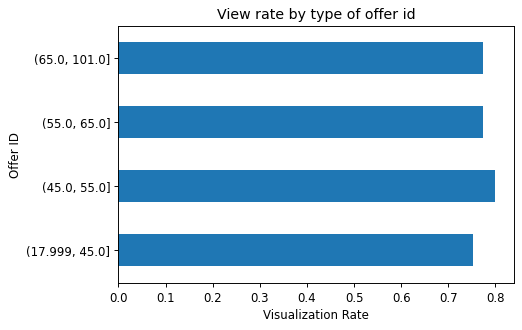

age_quartile
(17.999, 45.0]    0.751632
(45.0, 55.0]      0.798858
(55.0, 65.0]      0.773795
(65.0, 101.0]     0.773745
Name: viewed_rate, dtype: float64

In [25]:
user_offer_df2['age_quartile'] = pd.qcut(user_offer_df2['age'], 4)

plot_df = user_offer_df2.groupby('age_quartile')['viewed_rate'].mean().\
    sort_index(ascending=True)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer id')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer ID')
plt.show()

plot_df

For the old quarks, the proportions are very similar.  

Statistically checking for two sets of groups

In [26]:
aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(17.999, 45.0), metric='viewed_rate')

aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(65.0, 101.0), metric='viewed_rate')

p-value of 0.0. With confidence value of 0.05, (45.0, 55.0] and (17.999, 45.0] distributions are different
p-value of 0.0. With confidence value of 0.05, (45.0, 55.0] and (65.0, 101.0] distributions are different


Different from distributions to type of offer, in this case the old quartile groups do not have statistical differences.  
So, all these groups have the same proportion in Viewing Offers

The same analysis for income groups

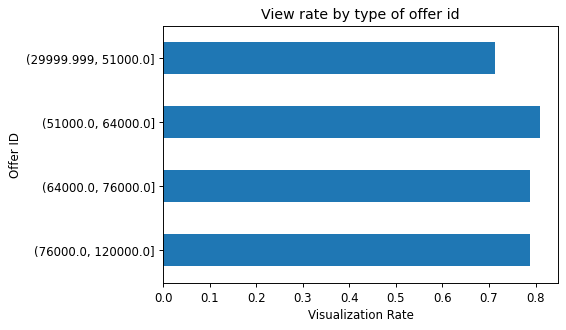

income_quartile
(76000.0, 120000.0]     0.788429
(64000.0, 76000.0]      0.787865
(51000.0, 64000.0]      0.808519
(29999.999, 51000.0]    0.713329
Name: viewed_rate, dtype: float64

In [66]:
user_offer_df2['income_quartile'] = pd.qcut(user_offer_df2['income'], 4)

plot_df = user_offer_df2.groupby('income_quartile')['viewed_rate'].mean().\
    sort_index(ascending=False)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer id')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer ID')
plt.show()

plot_df

In [28]:
aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='income_quartile', 
     cat1=pd.Interval(29999.999, 51000.0), cat2=pd.Interval(51000.0, 64000.0), metric='viewed_rate')

aux_fun.test_proportions_in_dataframe(df=user_offer_df2, column='income_quartile', 
     cat1=pd.Interval(76000.0, 120000.0), cat2=pd.Interval(51000.0, 64000.0), metric='viewed_rate')


p-value of 1.0. With confidence value of 0.05, (29999.999, 51000.0] and (51000.0, 64000.0] distributions are equal
p-value of 1.0. With confidence value of 0.05, (76000.0, 120000.0] and (51000.0, 64000.0] distributions are equal


Again, view rates for income groups do not differ

Opening for offer types

Perhaps age and income views vary based on the type of offer

In [29]:
# Get the types of different offers
offer_types = portfolio2.offer_type.unique()
offer_types

array(['bogo', 'informational', 'discount'], dtype=object)

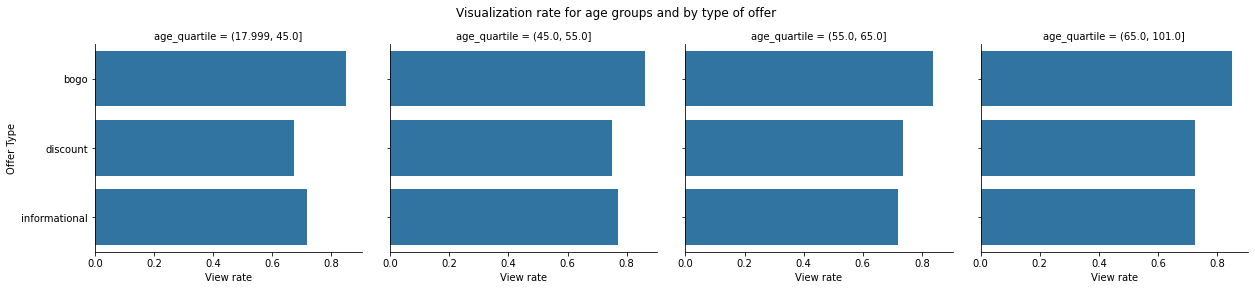

,offer_type,age_quartile,viewed_rate
0,bogo,"(17.999, 45.0]",0.847856
1,bogo,"(45.0, 55.0]",0.860984
2,bogo,"(55.0, 65.0]",0.838852
3,bogo,"(65.0, 101.0]",0.848857
4,discount,"(17.999, 45.0]",0.671880
5,discount,"(45.0, 55.0]",0.751028
6,discount,"(55.0, 65.0]",0.736365
7,discount,"(65.0, 101.0]",0.724396
8,informational,"(17.999, 45.0]",0.718604
9,informational,"(45.0, 55.0]",0.769055


In [30]:
# Running for each offer type

plot_df = user_offer_df2.groupby(['offer_type', 'age_quartile'], 
    as_index=False)['viewed_rate'].mean().sort_index(ascending=True)

# Ploting in grid
g = sns.FacetGrid(data=plot_df, col='age_quartile', sharex=True)
g.map_dataframe(sns.barplot, y='offer_type', x='viewed_rate')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visualization rate for age groups and by type of offer')
g.set_xlabels('View rate')
g.set_ylabels('Offer Type')

fig = plt.gcf()

fig.set_size_inches(18,4)
plt.show()

plot_df

Nothing different from the porportions again. High values are for BOGO offers, which had already been seen previously.  

For income quartiles

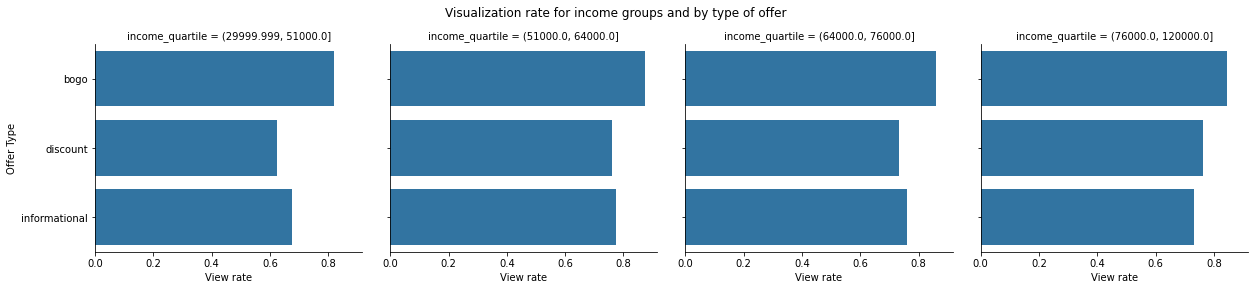

,offer_type,income_quartile,viewed_rate
0,bogo,"(29999.999, 51000.0]",0.821200
1,bogo,"(51000.0, 64000.0]",0.872745
2,bogo,"(64000.0, 76000.0]",0.859900
3,bogo,"(76000.0, 120000.0]",0.844359
4,discount,"(29999.999, 51000.0]",0.624021
5,discount,"(51000.0, 64000.0]",0.761701
6,discount,"(64000.0, 76000.0]",0.730709
7,discount,"(76000.0, 120000.0]",0.761729
8,informational,"(29999.999, 51000.0]",0.675055
9,informational,"(51000.0, 64000.0]",0.774109


In [31]:
# Running for each offer type

plot_df = user_offer_df2.groupby(['offer_type', 'income_quartile'], 
    as_index=False)['viewed_rate'].mean().sort_index(ascending=True)

# Ploting in grid
g = sns.FacetGrid(data=plot_df, col='income_quartile', sharex=True)
g.map_dataframe(sns.barplot, y='offer_type', x='viewed_rate')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visualization rate for income groups and by type of offer')
g.set_xlabels('View rate')
g.set_ylabels('Offer Type')

fig = plt.gcf()

fig.set_size_inches(18,4)
plt.show()

plot_df

Same situation, without any big tendecy.  

A point that can be highlighted is that the discount type has lower proportion for the first quatis (both age and income). In other groups, the proportions follow the general trend already seen between types of offers.

If well observe, rates are many similar to age groupings and income. This is related to the distribution of data.People from the first quartile old are also more present in the quartile of income

In [32]:
user_offer_df2.groupby(['age_quartile', 'income_quartile']).agg(count=('income_quartile', 'count'))

count
age_quartile   income_quartile            
(17.999, 45.0] (29999.999, 51000.0]   7300
               (51000.0, 64000.0]     4525
               (64000.0, 76000.0]     3299
               (76000.0, 120000.0]    1114
(45.0, 55.0]   (29999.999, 51000.0]   2726
               (51000.0, 64000.0]    10553
               (64000.0, 76000.0]     2433
               (76000.0, 120000.0]    3901
(55.0, 65.0]   (29999.999, 51000.0]   2771
               (51000.0, 64000.0]     2499
               (64000.0, 76000.0]     2465
               (76000.0, 120000.0]    4820
(65.0, 101.0]  (29999.999, 51000.0]   3183
               (51000.0, 64000.0]     2989
               (64000.0, 76000.0]     2829
               (76000.0, 120000.0]    5739

##### 3. Complete Rate

Após recebida, a oferta pode ser visualizada ou não.  
Para completar uma oferta não é necessário olhar para ela.  

Completation by Type of Offer

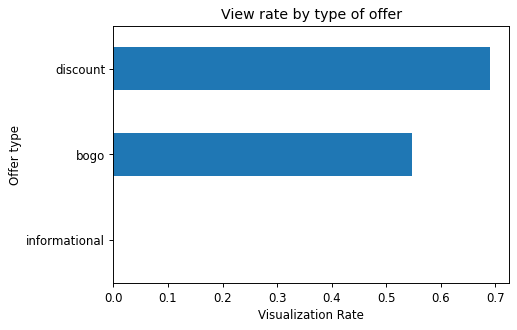

offer_type
informational    0.000000
bogo             0.547132
discount         0.690117
Name: completed_rate, dtype: float64

In [33]:
plot_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

plot_df = plot_df.groupby('offer_type')['completed_rate'].mean().\
    sort_values(ascending=True)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer type')
plt.show()

plot_df

What looks like is that buy-one get one offers has a slightly larger viewing fee compared to the other two.

Fact that proportions are not really so far from one another
However, it is possible to test whether these proportions are statistically different with a test of proprotions between independent samples (and considering that they are normal).

In [34]:
# Proportion test between two samples
# The test is one-tailed greater than

list_set = [['discount', 'bogo']]

analisys_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

for set_ in list_set:
    aux_fun.test_proportions_in_dataframe(df=analisys_df, column='offer_type', 
        cat1=set_[0], cat2=set_[1], metric='completed_rate')

p-value of 0.0. With confidence value of 0.05, discount and bogo distributions are different


Como visto, a taxa de completação de ofertas é maior para ofertas do tipo discount, validado estatisticamente.  

Assim, quando comparado com bogo, pode-se dizer que as pessoas usam mais os discontos que as ofertas de comprar um e levar outro


Complete by offer id

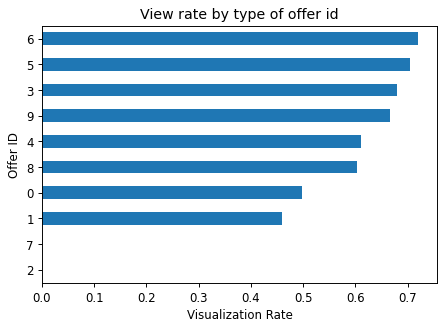

offer_id_rec
2    0.000000
7    0.000000
1    0.460258
0    0.497446
8    0.602216
4    0.610575
9    0.666667
3    0.680421
5    0.704267
6    0.720540
Name: completed_rate, dtype: float64

In [35]:
plot_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

plot_df = plot_df.groupby('offer_id_rec')['completed_rate'].mean().\
    sort_values(ascending=True)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer id')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer ID')
plt.show()

plot_df

Ofertas 7 e 2 são informational, logo, não tem completação.  
Para as demais, nota-se que a oferta 6 e 5 têm maior completação. 
A oferta 1 tem uma boa taxa de visualição, mas não foi tão completada quanto as demais.  
A oferta 8 tinha uma taxa de visualização alta, porém, mostrou taxa de completação baixa. 

A razão para isso talvez seja melhor vista abaixo

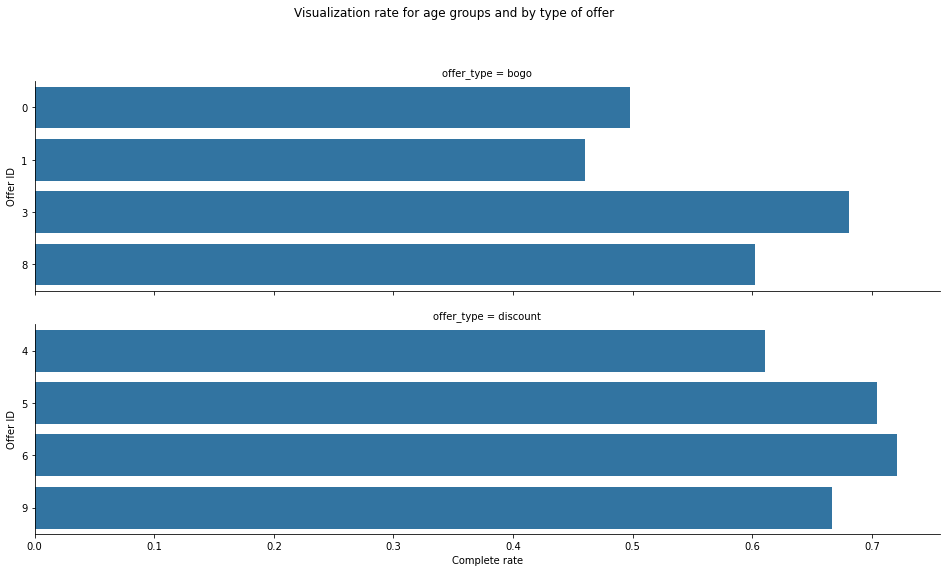

In [36]:
# Separating by Type of Offer

plot_df = user_offer_df2.loc[(user_offer_df2['viewed_rate'] != 0) &
    (user_offer_df2['offer_type'] != 'informational')]

plot_df = plot_df.groupby(['offer_type', 'offer_id_rec'], as_index=False)['completed_rate'].mean()

plot_df = plot_df.astype({'offer_id_rec': str})

# Ploting in grid
g = sns.FacetGrid(data=plot_df, row='offer_type', sharey=False)
g.map_dataframe(sns.barplot, y='offer_id_rec', x='completed_rate')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visualization rate for age groups and by type of offer')
g.set_xlabels('Complete rate')
g.set_ylabels('Offer ID')

fig = plt.gcf()

fig.set_size_inches(15,8)
plt.show()



Pelo que é visualizado, as ofertas de tipo disconto tem realmente maiores taxa de completação em comparação com as ofertas do tipo bogo. 

Assim, para os usuários, as ofertas de disconto parecem mais chamativas que as de oferta de ganhar outro de graça

Completation by ages

Dividing the range of ages in quartiles to see distribution of visualization rate

C:\Users\ismae\AppData\Local\Temp/ipykernel_12772/769449987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['age_quartile'] = pd.qcut(plot_df['age'], 4)


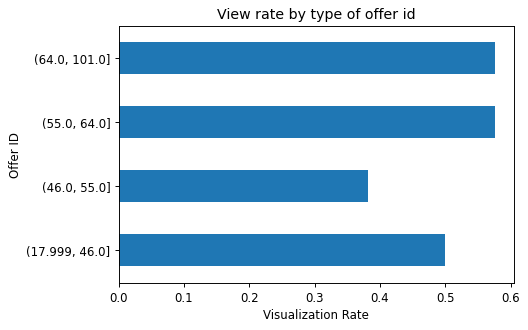

age_quartile
(17.999, 46.0]    0.499883
(46.0, 55.0]      0.381453
(55.0, 64.0]      0.575986
(64.0, 101.0]     0.576001
Name: completed_rate, dtype: float64

In [37]:
plot_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

plot_df['age_quartile'] = pd.qcut(plot_df['age'], 4)

plot_df = plot_df.groupby('age_quartile')['completed_rate'].mean().\
    sort_index(ascending=True)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer id')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer ID')
plt.show()

plot_df

For the old quarks, the proportions are very similar.  

Statistically checking for two sets of groups

In [38]:
analisys_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(17.999, 45.0), metric='completed_rate')

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='age_quartile', 
     cat1=pd.Interval(45.0, 55.0), cat2=pd.Interval(65.0, 101.0), metric='completed_rate')

p-value of 1.0. With confidence value of 0.05, (45.0, 55.0] and (17.999, 45.0] distributions are equal
p-value of 1.0. With confidence value of 0.05, (45.0, 55.0] and (65.0, 101.0] distributions are equal


Different from distributions to type of offer, in this case the old quartile groups do not have statistical differences.  
So, all these groups have the same proportion in Viewing Offers

The same analysis for income groups

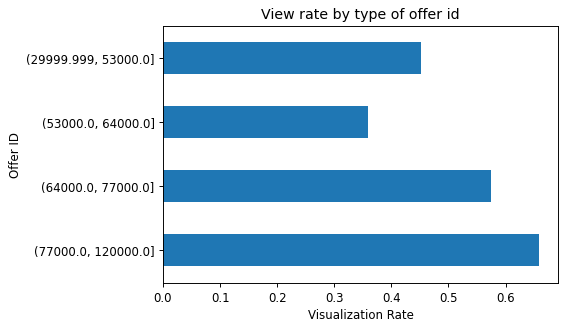

income_quartile
(77000.0, 120000.0]     0.659279
(64000.0, 77000.0]      0.574694
(53000.0, 64000.0]      0.358207
(29999.999, 53000.0]    0.452366
Name: completed_rate, dtype: float64

In [65]:

plot_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

plot_df.loc[:, ['income_quartile']] =  pd.qcut(plot_df['income'], 4)

plot_df = plot_df.groupby('income_quartile')['completed_rate'].mean().\
    sort_index(ascending=False)

plt.figure(dpi=85)
plot_df.plot.barh()
plt.title('View rate by type of offer id')
plt.xlabel('Visualization Rate')
plt.ylabel('Offer ID')
plt.show()

plot_df

In [63]:
analisys_df = user_offer_df2.loc[user_offer_df2['viewed_rate'] != 0]

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='income_quartile', 
     cat1=pd.Interval(29999.999, 51000.0), cat2=pd.Interval(51000.0, 64000.0), metric='completed_rate')

aux_fun.test_proportions_in_dataframe(df=analisys_df, column='income_quartile', 
     cat1=pd.Interval(76000.0, 120000.0), cat2=pd.Interval(51000.0, 64000.0), metric='completed_rate')


p-value of 0.0. With confidence value of 0.05, (29999.999, 51000.0] and (51000.0, 64000.0] distributions are different
p-value of 0.0. With confidence value of 0.05, (76000.0, 120000.0] and (51000.0, 64000.0] distributions are different


Estatisticamente os valores diferem.  

Observa-se que para as rendas de valores maiores (último quartil), as taxas de completação são maiores comparadas aos outros grupos, enquanto as taxas de visualização eram muito próximas.

Opening for offer types

Perhaps age and income views vary based on the type of offer

In [67]:
# Get the types of different offers
offer_types = portfolio2.offer_type.unique()
offer_types

array(['bogo', 'informational', 'discount'], dtype=object)

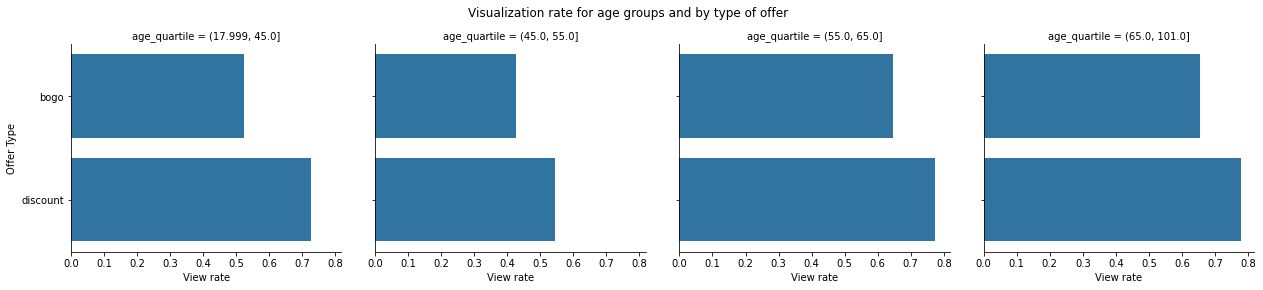

,offer_type,age_quartile,completed_rate
0,bogo,"(17.999, 45.0]",0.524379
1,bogo,"(45.0, 55.0]",0.426193
2,bogo,"(55.0, 65.0]",0.646890
3,bogo,"(65.0, 101.0]",0.653537
4,discount,"(17.999, 45.0]",0.727293
5,discount,"(45.0, 55.0]",0.544241
6,discount,"(55.0, 65.0]",0.772460
7,discount,"(65.0, 101.0]",0.779709


In [72]:
# Running for each offer type

plot_df = user_offer_df2.loc[(user_offer_df2['viewed_rate'] != 0) &
    (user_offer_df2['offer_type'] != 'informational')]

plot_df = plot_df.groupby(['offer_type', 'age_quartile'], 
    as_index=False)['completed_rate'].mean().sort_index(ascending=True)

# Ploting in grid
g = sns.FacetGrid(data=plot_df, col='age_quartile', sharex=True)
g.map_dataframe(sns.barplot, y='offer_type', x='completed_rate')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visualization rate for age groups and by type of offer')
g.set_xlabels('View rate')
g.set_ylabels('Offer Type')

fig = plt.gcf()

fig.set_size_inches(18,4)
plt.show()

plot_df

Em todos os grupos, nota-se os valores mais altos em disconto, ao invés de bogo

For income quartiles

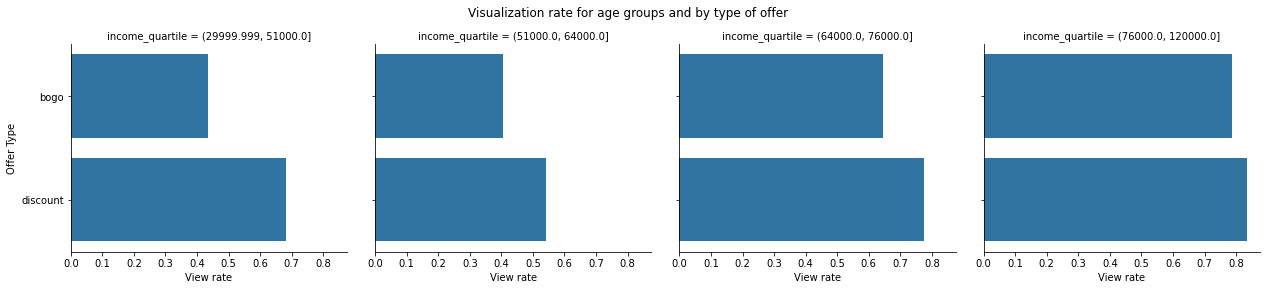

,offer_type,income_quartile,completed_rate
0,bogo,"(29999.999, 51000.0]",0.434131
1,bogo,"(51000.0, 64000.0]",0.403771
2,bogo,"(64000.0, 76000.0]",0.645102
3,bogo,"(76000.0, 120000.0]",0.785551
4,discount,"(29999.999, 51000.0]",0.681807
5,discount,"(51000.0, 64000.0]",0.541312
6,discount,"(64000.0, 76000.0]",0.775246
7,discount,"(76000.0, 120000.0]",0.833929


In [73]:
# Running for each offer type

plot_df = user_offer_df2.loc[(user_offer_df2['viewed_rate'] != 0) &
    (user_offer_df2['offer_type'] != 'informational')]

plot_df = plot_df.groupby(['offer_type', 'income_quartile'], 
    as_index=False)['completed_rate'].mean().sort_index(ascending=True)

# Ploting in grid
g = sns.FacetGrid(data=plot_df, col='income_quartile', sharex=True)
g.map_dataframe(sns.barplot, y='offer_type', x='completed_rate')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visualization rate for age groups and by type of offer')
g.set_xlabels('View rate')
g.set_ylabels('Offer Type')

fig = plt.gcf()

fig.set_size_inches(18,4)
plt.show()

plot_df

Para o grupo com maior taxa de compeltação (último quartil de renda), tanto bogo quando disconto é visto por igual.  

Já para outros grupos, nota-se que o grupo do primeiro quartil tem maior taxa de completar discontos ao invés de bogo.